In [1]:
import pandas as pd
import numpy as np
import os.path as op
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}  

In [2]:
images =[]
label_df= pd.DataFrame()
for year in range(1993,2000):
    train = np.memmap(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    train = np.array(train/255.0)
    images.append(train)
    label_df_train = pd.read_feather(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
    label_df= pd.concat([label_df,label_df_train],axis= 0)
images = np.concatenate(images, axis=0, out=None)
type(images)

numpy.ndarray

In [3]:
x_test =[]
y_test= pd.DataFrame()
for year in range(2000,2005):
    train = np.memmap(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r+').reshape(\
                        (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    train = np.array(train/255.0)
    x_test.append(train)
    label_df_train = pd.read_feather(op.join("monthly_20d/", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
    y_test= pd.concat([y_test,label_df_train],axis= 0)
x_test = np.concatenate(x_test, axis=0, out=None)
y_test = y_test['Retx_20d'].copy()
y_test[y_test.isna()]=0
x_test = np.reshape(x_test,( -1,1,64,60))
y_test = np.array(y_test).reshape((-1,1))

In [4]:
y = label_df['Retx_20d'].copy()
# y = pd.get_dummies(y)
y[y.isna()]=0
y = np.array(y).reshape((-1,1))

images = np.reshape(images,( -1,1,64,60))
x_train, x_val, y_train, y_val = train_test_split(images, y, test_size=0.3, random_state=10, shuffle=True)

print('shape train:',np.shape(x_train),'shape validation',np.shape(x_val),'shape test',np.shape(x_test))

shape train: (486409, 1, 64, 60) shape validation (208462, 1, 64, 60) shape test (436268, 1, 64, 60)


In [5]:
# y = label_df['Retx_20d'].copy()
# y[y.isna()]=0
# y.isna().sum()

In [5]:
import torch
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms

import torch.utils.data as Dataset
from torchsummary import summary
torch.cuda.empty_cache()   

In [6]:
torch.cuda.is_available()

True

In [7]:
class subDataset(Dataset.Dataset):
    #初始化，定义数据内容和标签
    def __init__(self, Data, Label):
        self.Data = Data
        self.Label = Label
    #返回数据集大小
    def __len__(self):
        return len(self.Data)
    #得到数据内容和标签
    def __getitem__(self, index):
        data = torch.Tensor(self.Data[index])
        label = torch.Tensor(self.Label[index])
        return data, label

In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        print(self.path)
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
train_dataset = subDataset(x_train, y_train)
val_dataset = subDataset(x_val, y_val)
test_dataset = subDataset(x_test, y_test)

In [42]:
# train_dataset[0]
train_loader = data.DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader= data.DataLoader(val_dataset,batch_size=128,shuffle=True)
test_loader = data.DataLoader(test_dataset,batch_size=128,shuffle=True)


In [27]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1,
                            out_channels=64,
                            kernel_size=[5,3],
                            stride=[1,3],
                            padding=[2,1],
                            dilation =[1,2]
                            ),
            torch.nn.BatchNorm2d(64),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(64,128, kernel_size=[5,3], padding=[2,1],stride=[1,3]),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(128,256, kernel_size=[5,3],padding=[2,1], stride=[1,3]),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(256,512, kernel_size=[5,3],padding=[2,1],stride=[1,3]),
            torch.nn.BatchNorm2d(512),
            torch.nn.Dropout(0.5),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 1))
        )
        self.flatten = nn.Flatten()
        self.fc1 = torch.nn.Linear(512*4,1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.flatten(x)
        x = self.fc1(x)
        return x


In [28]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_ids=range(torch.cuda.device_count())
print(device_ids)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs")
# dim = 0 [64, xxx] -> [32, ...], [32, ...] on 2GPUs
model = nn.DataParallel(model, device_ids=device_ids)
model.cuda(device=device_ids[0]) 

range(0, 4)
Let's use 4 GPUs


DataParallel(
  (module): CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1), dilation=(1, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [29]:
summary(model, input_size=(1,64,60),device = "cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 20]           1,024
            Conv2d-2           [-1, 64, 64, 20]           1,024
       BatchNorm2d-3           [-1, 64, 64, 20]             128
           Dropout-4           [-1, 64, 64, 20]               0
       BatchNorm2d-5           [-1, 64, 64, 20]             128
         LeakyReLU-6           [-1, 64, 64, 20]               0
         MaxPool2d-7           [-1, 64, 32, 20]               0
           Dropout-8           [-1, 64, 64, 20]               0
         LeakyReLU-9           [-1, 64, 64, 20]               0
           Conv2d-10           [-1, 128, 32, 7]         123,008
        MaxPool2d-11           [-1, 64, 32, 20]               0
           Conv2d-12           [-1, 128, 32, 7]         123,008
      BatchNorm2d-13           [-1, 128, 32, 7]             256
          Dropout-14           [-1, 128

In [30]:
patience= 6
epochs=120
loss_func = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(),lr=0.00001)
early_stopping = EarlyStopping(patience, path= '../cnn_model/cnn_torch/ret_20_pred_checkpoint.pt',verbose=True)

../cnn_model/cnn_torch/ret_20_pred_checkpoint.pt


In [31]:
# summary(model, input_size=(1,64,60), device="cuda")
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        print(m)
        nn.init.xavier_normal_(m.weight.data)
        # nn.init.kaiming_normal(m.weight.data)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)

Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1), dilation=(1, 2))
Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))
Conv2d(256, 512, kernel_size=(5, 3), stride=(1, 3), padding=(2, 1))


epoch: 1:  iteration: 1:	 loss: 0.03254452347755432
val loss:	 0.0242947
epoch: 1:  iteration: 21:	 loss: 0.029633579775691032
epoch: 1:  iteration: 41:	 loss: 0.019318651407957077
epoch: 1:  iteration: 61:	 loss: 0.020320624113082886
epoch: 1:  iteration: 81:	 loss: 0.034864019602537155
epoch: 1:  iteration: 101:	 loss: 0.03769470378756523
val loss:	 0.044998594
epoch: 1:  iteration: 121:	 loss: 0.037856653332710266
epoch: 1:  iteration: 141:	 loss: 0.020882241427898407
epoch: 1:  iteration: 161:	 loss: 0.07306124269962311
epoch: 1:  iteration: 181:	 loss: 0.026083074510097504
epoch: 1:  iteration: 201:	 loss: 0.025807388126850128
val loss:	 0.14170116
epoch: 1:  iteration: 221:	 loss: 0.014948343858122826
epoch: 1:  iteration: 241:	 loss: 0.03244765102863312
epoch: 1:  iteration: 261:	 loss: 0.022918174043297768
epoch: 1:  iteration: 281:	 loss: 0.014522850513458252
epoch: 1:  iteration: 301:	 loss: 0.014734743162989616
val loss:	 0.05831874
epoch: 1:  iteration: 321:	 loss: 0.032408

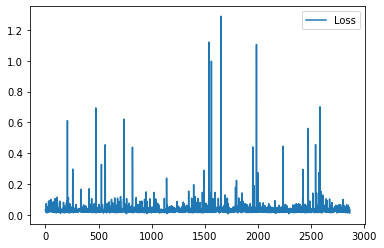

In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
# Accuracy_Score = accuracy_score(prediction, y_res)
loss_count= []
global_loss_train = []
global_loss_test = []
for epoch in range(epochs):
    for i,(x,y) in enumerate(train_loader):
        batch_x = Variable(x.cuda(device=device_ids[0])) # torch.Size([128,1,64,60])
        batch_y = Variable(y.cuda(device=device_ids[0]))
        # 获取最后输出
        out = model(batch_x.float()) # torch.Size([128,3])
        # print(np.shape(out))
        # 获取损失
        loss = loss_func(out,batch_y)

        opt.zero_grad()  # 
        loss.backward() # 误差反向传播，计算参数更新值
        opt.step() # 将参数更新值施加到net的parmeters上
        if i%20 == 0:
            temp = loss.cpu()
            loss_count.append(temp.detach().numpy())
            print('epoch: {}: '.format(epoch+1),'iteration: {}:\t'.format(i+1),'loss:', loss.item())
            torch.save(model.state_dict(),r'../cnn_model/cnn_torch/ret_20_pred_checkpoint.pt')

        if i % 100 == 0:
            for a,b in val_loader:
                val_x = Variable(a.cuda(device=device_ids[0]))
                val_y = Variable(b.cuda(device=device_ids[0]))
                out = model(val_x)

                accuracy = loss_func(out, val_y)
                print('val loss:\t',accuracy.cpu().detach().numpy())
                break
    early_stopping(loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        # 结束模型训练
        break
    if epoch % 1 == 0:
        print('----------------epoch end---------------------', epoch)
        prediction_train = model(batch_x)
        loss_train = loss_func(prediction_train, batch_y.squeeze().long())
        global_loss_train.append(loss_train.cpu().detach().numpy())
        print('|loss_train|', loss_train.cpu().item())
        for a,b in test_loader:
            test_x = Variable(a.cuda(device=device_ids[0]))
            test_y = Variable(b.cuda(device=device_ids[0]))
            prediction_test = model(test_x)
            loss_test = loss_func(prediction_test, test_y.squeeze().long())
            global_loss_test.append(loss_test.cpu().detach().numpy())
            print('|loss_test|', loss_test.cpu().item())
            break    
model.load_state_dict(torch.load('../cnn_model/cnn_torch/ret_20_pred_checkpoint.pt'))
plt.figure('PyTorch_CNN_Loss')
plt.plot(loss_count,label='Loss')
plt.legend()
plt.show()

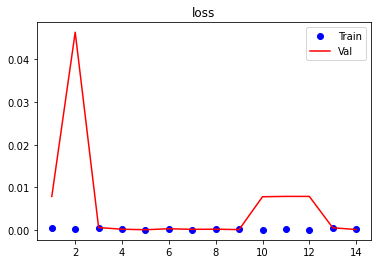

In [47]:
epochs = range(1, len(global_loss_test) + 1)

plt.figure()
plt.plot(epochs, global_loss_train, 'bo', label='Train')
plt.plot(epochs, global_loss_test, 'r', label='Val')
plt.legend()
plt.title('loss')
plt.show()


In [ ]:
model.load_state_dict(torch.load('../cnn_model/cnn_torch/ret_20_pred_checkpoint.pt'))
global_loss_test = []

prediction = []
y_res = []
for a,b in test_loader:
    test_x = Variable(a.cuda(device=device_ids[0]))
    test_y = Variable(b.cuda(device=device_ids[0]))
    prediction_test = model(test_x)
    loss_test = loss_func(prediction_test, test_y.squeeze().long())
    global_loss_test.append(loss_test.cpu().detach().numpy())

    prediction.extend(prediction_test.cpu().detach().numpy().tolist())
    y_res.extend(np.array(b).tolist())
    print('|loss_test|', loss_test.cpu().item())


|loss_test| 0.00012804733705706894
|loss_test| 0.00010490341810509562
|loss_test| 0.00011349951091688126
|loss_test| 0.015572338365018368
|loss_test| 0.00012829412298742682
|loss_test| 0.007843105122447014
|loss_test| 0.00010233531065750867
|loss_test| 0.007853399030864239
|loss_test| 0.00014569262566510588
|loss_test| 0.0001208672983921133
|loss_test| 0.007845070213079453
|loss_test| 0.031216304749250412
|loss_test| 0.00014160758291836828
|loss_test| 0.007864118553698063
|loss_test| 0.00012176661402918398
|loss_test| 0.00011510700278449804
|loss_test| 0.007860618643462658
|loss_test| 0.0001187820962513797
|loss_test| 0.00013398032751865685
|loss_test| 0.00011104786972282454
|loss_test| 0.00011249647650402039
|loss_test| 9.496074198978022e-05
|loss_test| 0.00010178674710914493
|loss_test| 0.0001252337679034099
|loss_test| 0.007838600315153599
|loss_test| 0.07021061331033707
|loss_test| 0.015566709451377392
|loss_test| 0.00010614660277497023
|loss_test| 0.00011973798245890066
|loss_test

[array(0.00788334, dtype=float32),
 array(0.04637275, dtype=float32),
 array(0.00058536, dtype=float32),
 array(0.00019132, dtype=float32),
 array(7.429613e-05, dtype=float32),
 array(0.00029939, dtype=float32),
 array(0.00016641, dtype=float32),
 array(0.00019758, dtype=float32),
 array(0.00010319, dtype=float32),
 array(0.00780523, dtype=float32),
 array(0.00788822, dtype=float32),
 array(0.00788319, dtype=float32),
 array(0.00053203, dtype=float32),
 array(0.00011929, dtype=float32)]